In [202]:
import sys
import os
import pandas as pd
import numpy as np
import torch
from torchmetrics import Accuracy
from matplotlib import pyplot as plt

from importlib import reload

<module 'concept_gradient' from '/nfs/data/andrewbai/auto-tcav/concept_gradient.py'>

In [24]:
paths = ['../../auto-tcav/']
for path in paths:
    if os.path.abspath(path) not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
        print(os.path.abspath(path))

/nfs/data/andrewbai/auto-tcav


In [221]:
import concept_gradient
from concept_gradient import ConceptGradients
reload(concept_gradient)

import analysis_utils
from analysis_utils import ClassifierHead
reload(analysis_utils)

<module 'analysis_utils' from '/nfs/data/andrewbai/auto-tcav/notebooks/analysis_utils.py'>

### Preprocess data

In [2]:
%ls /home/andrewbai/data/myocardial/

myocardial_infarction_complicatiions_database.csv


In [108]:
data_path = '/home/andrewbai/data/myocardial/myocardial_infarction_complicatiions_database.csv'
df = pd.read_csv(data_path)
df_X = df.iloc[:, :112]
df_C = df.iloc[:, 112:123]
df_Y = df.iloc[:, 123]
df.shape, df_X.shape, df_C.shape, df_Y.shape

((1700, 124), (1700, 112), (1700, 11), (1700,))

In [109]:
df_C.isna().sum()

FIBR_PREDS    0
PREDS_TAH     0
JELUD_TAH     0
FIBR_JELUD    0
A_V_BLOK      0
OTEK_LANC     0
RAZRIV        0
DRESSLER      0
ZSN           0
REC_IM        0
P_IM_STEN     0
dtype: int64

In [110]:
df_Y.value_counts()

0    1429
1     110
3      54
7      27
6      27
4      23
2      18
5      12
Name: LET_IS, dtype: int64

In [111]:
for i, col in enumerate(df_X.columns):
    nan_rate = df_X[col].isna().mean()
    if nan_rate > 0.25:
        print(i + 1, col, nan_rate)

8 IBS_NASL 0.9576470588235294
35 S_AD_KBRIG 0.6329411764705882
36 D_AD_KBRIG 0.6329411764705882
89 KFK_BLOOD 0.9976470588235294
96 NA_KB 0.3864705882352941
97 NOT_NA_KB 0.40352941176470586
98 LID_KB 0.3982352941176471


In [112]:
# remove features with NaN rate greater then 0.1
t = 0.25
df_X = df_X.drop(labels=[col for col in df_X.columns if df_X[col].isna().mean() > t], axis=1)
df_X = df_X.drop('ID', axis=1)

In [113]:
# fill NaN with mode
df_X = df_X.fillna(df_X.mean().iloc[0])

In [114]:
# normalize
df_X = (df_X - df_X.mean(0)) / df_X.std(0)

In [115]:
df_X

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
0,1.348036,0.771941,0.421517,-0.344586,-0.227670,-0.094501,0.284570,-0.076632,-0.233794,-0.198689,...,-0.146146,-0.270312,-0.293947,0.074898,-0.10615,-0.212006,-0.053461,-0.058223,-0.100404,-0.131154
1,-0.610410,0.771941,0.097504,-0.413109,-0.308699,-0.287048,-0.378949,-0.076632,-0.569376,-0.198689,...,0.064480,-0.270312,-0.293947,0.074898,-0.10615,-0.025182,-0.053461,-0.058223,-0.100404,0.036397
2,-0.877471,0.771941,-0.226510,-0.413109,-0.308699,-0.094501,0.063397,-0.076632,-0.473495,-0.198689,...,0.485732,-0.138722,-0.172603,0.074898,0.09538,-0.212006,-0.053461,-0.058223,-0.100404,-0.131154
3,0.546854,-1.294673,-0.226510,-0.413109,-0.308699,-0.094501,0.063397,-0.076632,-0.425555,-0.106409,...,-0.146146,-0.270312,-0.293947,-0.136458,-0.10615,-0.025182,-0.053461,-0.058223,-0.100404,-0.131154
4,-0.165308,0.771941,-0.226510,-0.413109,-0.308699,-0.094501,0.284570,-0.076632,-0.233794,-0.198689,...,-0.146146,-0.270312,-0.293947,-0.136458,-0.10615,-0.025182,-0.217344,-0.058223,-0.100404,0.036397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,1.348036,-1.294673,-0.226510,-0.139015,-0.146641,-0.190775,0.063397,-0.076632,-0.233794,-0.198689,...,-0.146146,3.799567,3.459035,-0.136458,-0.10615,-0.212006,-0.217344,-0.222212,-0.100404,-0.131154
1696,0.724894,-1.294673,-0.226510,-0.001969,-0.146641,-0.190775,0.063397,-0.076632,-0.233794,-0.198689,...,-0.146146,3.799567,3.459035,0.074898,-0.10615,-0.212006,-0.217344,-0.222212,-0.100404,-0.131154
1697,-0.610410,0.771941,0.745530,-0.001969,-0.146641,-0.094501,-0.378949,-0.076632,-0.569376,-0.198689,...,-0.146146,-0.270312,-0.293947,-0.136458,0.09538,-0.212006,-0.053461,-0.058223,-0.100404,-0.131154
1698,1.526077,-1.294673,0.421517,-0.276062,-0.146641,-0.190775,0.063397,-0.076632,-0.233794,5.509498,...,0.064480,3.799567,3.459035,0.074898,-0.10615,-0.025182,-0.053461,-0.058223,-0.100404,-0.131154


In [117]:
df_Y = (df_Y != 0).astype(int)

In [118]:
df_Y

0       0
1       0
2       0
3       0
4       0
       ..
1695    1
1696    1
1697    1
1698    1
1699    1
Name: LET_IS, Length: 1700, dtype: int64

In [122]:
np.savez('/home/andrewbai/data/myocardial/data.npz', 
         X=df_X.values, feat_labels=df_X.columns, 
         C=df_C.values, concept_labels=df_C.columns,
         Y=df_Y.values, target_label=df_Y.name)

### Train target model

In [228]:
with np.load('/home/andrewbai/data/myocardial/data.npz', allow_pickle=True) as f:
    X_tsr = torch.from_numpy(f['X']).float()
    C_tsr = torch.from_numpy(f['C']).float()
    Y_tsr = torch.from_numpy(f['Y']).float()
    concept_labels = f['concept_labels']
print(X_tsr.shape, C_tsr.shape, Y_tsr.shape)

torch.Size([1700, 104]) torch.Size([1700, 11]) torch.Size([1700])


In [172]:
model = ClassifierHead(X_tsr.shape[1], 1)

In [173]:
dset = torch.utils.data.TensorDataset(X_tsr, Y_tsr)
dl = torch.utils.data.DataLoader(dset, batch_size=32, shuffle=True, drop_last=False)

In [174]:
n_epochs = 200

In [175]:
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=((Y_tsr == 0).sum() / (Y_tsr == 1).sum()))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [176]:
for epoch in range(n_epochs):
    loss = []
    for x, y in dl:
        optimizer.zero_grad()
        pred_y = model(x).squeeze(-1)
        loss_ = loss_fn(pred_y, y)
        loss_.backward()
        optimizer.step()
        loss.append(loss_.item())
    print(epoch + 1, np.mean(loss))

1 0.956201720016974
2 0.8011297224848358
3 0.7148026178280512
4 0.6765006910319682
5 0.6484629636009535
6 0.638495421519986
7 0.6237402533491453
8 0.6079060252479933
9 0.6139968225249538
10 0.5961264255974028
11 0.5868044592164181
12 0.5817747380998399
13 0.5913094613287184
14 0.6015680388168052
15 0.5678488957109274
16 0.5710823276528606
17 0.5582914581453359
18 0.5642833878044728
19 0.5489958105263887
20 0.5530723264371907
21 0.5250787565277683
22 0.5266887407611918
23 0.5222556121923305
24 0.5448928276697794
25 0.5243256395613706
26 0.5156729152357137
27 0.5029992783718087
28 0.5034703485391758
29 0.5026148312069751
30 0.4968087689744102
31 0.5165754973336503
32 0.47776359098928944
33 0.48036343300784073
34 0.4998309678501553
35 0.48481337836495153
36 0.4911021838585536
37 0.4820535218826047
38 0.4766926428786031
39 0.4546092995614917
40 0.4655860068138551
41 0.48992871051585235
42 0.4557292654558464
43 0.43293807227854375
44 0.45602077383685996
45 0.45206439439897184
46 0.444483043

In [177]:
model.eval()
metric = Accuracy()
with torch.no_grad():
    for x, y in dl:
        pred_y = torch.sigmoid(model(x).squeeze(-1))
        metric(pred_y, y.int())
print(metric.compute())

tensor(0.9800)


In [178]:
(Y_tsr == 1).float().mean()

tensor(0.1594)

In [181]:
torch.save(model.state_dict(), "myocardial_target.pth")

### Train concept model

In [182]:
model = ClassifierHead(X_tsr.shape[1], C_tsr.shape[1])

dset = torch.utils.data.TensorDataset(X_tsr, C_tsr)
dl = torch.utils.data.DataLoader(dset, batch_size=32, shuffle=True, drop_last=False)

In [183]:
n_epochs = 200

In [184]:
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=((C_tsr == 0).sum(0) / (C_tsr == 1).sum(0)))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [185]:
for epoch in range(n_epochs):
    loss = []
    for x, y in dl:
        optimizer.zero_grad()
        pred_y = model(x)
        loss_ = loss_fn(pred_y, y)
        loss_.backward()
        optimizer.step()
        loss.append(loss_.item())
    print(epoch + 1, np.mean(loss))

1 1.2838492669441082
2 1.2789511724754616
3 1.2404698287999187
4 1.2359813893282856
5 1.218104268665667
6 1.1906649878731481
7 1.2077278329266443
8 1.169270184304979
9 1.1616609317285043
10 1.1470239438392498
11 1.1376922483797427
12 1.1247416569126978
13 1.1218866761083957
14 1.1122230026457045
15 1.1059979641879047
16 1.1169569337809528
17 1.09370493778476
18 1.0846837759017944
19 1.0766277898240972
20 1.0837672661851954
21 1.0746690145245306
22 1.0624317283983584
23 1.0513872923674408
24 1.058513996777711
25 1.0529040230645075
26 1.0484887979648732
27 1.0446678587683924
28 1.0308868995419256
29 1.0282817052470312
30 1.0331244943318543
31 1.025226186822962
32 1.0200529374458172
33 1.0092105545379497
34 1.0052015373000391
35 1.0081447881680947
36 1.0052560512666349
37 0.9933057968263272
38 0.9895529724933483
39 0.9898083828113697
40 1.0012659088329032
41 0.9805964987587046
42 0.9777082701524099
43 0.9978826332975317
44 0.9874610834651523
45 0.9647312351950893
46 0.9927962488598294
47 

In [186]:
model.eval()
metric = Accuracy(average=None, num_classes=C_tsr.shape[1])
with torch.no_grad():
    for x, y in dl:
        pred_y = torch.sigmoid(model(x))
        metric(pred_y, y.int())
print(metric.compute())

tensor([0.7176, 0.9618, 0.9112, 0.8459, 0.8324, 0.7671, 0.9047, 0.8029, 0.6535,
        0.6994, 0.7059])


In [187]:
(C_tsr == 1).float().mean(0)

tensor([0.1000, 0.0118, 0.0247, 0.0418, 0.0335, 0.0935, 0.0318, 0.0441, 0.2318,
        0.0935, 0.0871])

In [188]:
torch.save(model.state_dict(), "myocardial_concept.pth")

### CG

In [222]:
dset = torch.utils.data.TensorDataset(X_tsr, Y_tsr)
dl = torch.utils.data.DataLoader(dset, batch_size=32, shuffle=False, drop_last=False)

In [223]:
x2y_model = ClassifierHead(X_tsr.shape[1], 1, squeeze_final=True).eval()
x2y_model.load_state_dict(torch.load("myocardial_target.pth"))

x2c_model = ClassifierHead(X_tsr.shape[1], C_tsr.shape[1], squeeze_final=True).eval()
x2c_model.load_state_dict(torch.load("myocardial_concept.pth"))

<All keys matched successfully>

In [224]:
cg = ConceptGradients(forward_func=x2y_model, concept_forward_func=x2c_model)

In [225]:
attrs = []
for x, y in dl:
    x.requires_grad = True
    
    attr = cg.attribute(x, mode='chain_rule_independent', n_concepts=C_tsr.shape[1],
                        target_layer_name=None).detach().numpy()
    attrs.append(attr)
attrs = np.concatenate(attrs, axis=0)
attrs.shape

(1700, 11)

In [230]:
for k, v in zip(concept_labels, attrs.mean(0)):
    print(k, v)

FIBR_PREDS 2.2853854
PREDS_TAH 0.23617542
JELUD_TAH 0.5145928
FIBR_JELUD 0.91022927
A_V_BLOK 0.6909391
OTEK_LANC 1.5047054
RAZRIV 1.6168545
DRESSLER 0.31609365
ZSN 3.2653935
REC_IM 3.4656646
P_IM_STEN -1.4041386


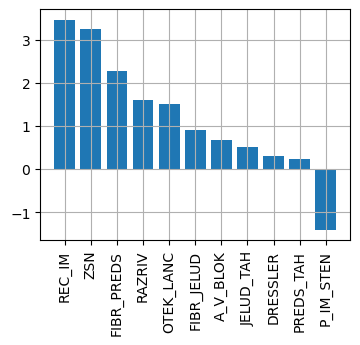

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sorted_indices = np.argsort(-attrs.mean(0))
ax.bar(concept_labels[sorted_indices], attrs.mean(0)[sorted_indices])
plt.xticks(rotation=90)
plt.grid()
plt.show()

* Atrial fibrillation (FIBR_PREDS): AF increases the risk of death by 1.5-fold in men and 1.9-fold in women [link](https://pubmed.ncbi.nlm.nih.gov/9737513/)
* Supraventricular tachycardia (PREDS_TAH): Although SVT is usually not life-threatening, many patients suffer recurrent symptoms that have a major impact on their quality of life. [link](https://pubmed.ncbi.nlm.nih.gov/19296791/)
* Ventricular tachycardia (JELUD_TAH) : The risk and consequently the therapeutic approach are determined by the underlying heart disease. Ventricular tachycardia is most commonly associated with ischemic heart disease or other forms of structural heart disease that are associated with a risk of sudden death. [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2664600/#:~:text=Ventricular%20tachycardia%20is%20most%20commonly,identified%20and%20benefit%20from%20ICDs.)
* Ventricular fibrillation (FIBR_JELUD): Patients developing VF in the setting of acute MI are at higher risk of in-hospital mortality. [link](https://pubmed.ncbi.nlm.nih.gov/24258072/)
* Third-degree AV block (A_V_BLOK): In patients with CHB complicating STEMI, there was no change in risk-adjusted in-hospital mortality during the study period. [link](https://pubmed.ncbi.nlm.nih.gov/29759406/)
* Pulmonary edema (OTEK_LANC): Pulmonary oedema in patients with acute MI hospitalized in coronary care units was reported to be associated with a high mortality of 38–57%. [link](https://pubmed.ncbi.nlm.nih.gov/10856726/)
* Myocardial rupture (RAZRIV): Myocardial rupture is a relatively rare and usually fatal complication of myocardial infarction (MI). [link](https://pubmed.ncbi.nlm.nih.gov/20598985/)
* Dressler syndrome (DRESSLER): The prognosis for patients with DS is typically considered to be quite good. [link](https://www.ncbi.nlm.nih.gov/books/NBK441988/)
* Chronic heart failure (ZSN): Patients with congestive heart failure have a high incidence of sudden cardiac death that is attributed to ventricular arrhythmias. The mortality rate in a group of patients with class III and IV heart failure is about 40% per year, and half of the deaths are sudden. [link](https://pubmed.ncbi.nlm.nih.gov/3552300/#:~:text=Abstract,of%20the%20deaths%20are%20sudden.)
* Relapse of the myocardial infarction (REC_IM): Recurrent infarction causes the most deaths following myocardial infarction with left ventricular dysfunction [link](https://pubmed.ncbi.nlm.nih.gov/15989909/#:~:text=Purpose%3A%20The%20development%20of%20left,directly%20or%20by%20provoking%20arrhythmias.)
* Post-infarction angina (P_IM_STEN): After adjustment, angina was only weakly associated with cardiovascular death, myocardial infarction, or stroke, but significantly associated with heart failure, cardiovascular hospitalization, and coronary revascularization. [link](https://www.ahajournals.org/doi/10.1161/JAHA.116.004080)